In [1]:
from __future__ import unicode_literals, print_function, division

import os
from io import open
import sys
import math
import random
import argparse
import operator
import pdb

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


from collections import defaultdict
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Kyle's attempt
import faker
from faker import Faker
import pandas as pd
import numpy as np
import re
from string import punctuation
import glob
import unicodedata
import string
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fake = Faker()

In [2]:
# reading in some data to help with training
ccs= pd.read_csv('datasets/lookups/county_cc_c_number.csv')
cc= pd.read_csv('datasets/lookups/continent_code.csv')

In [3]:
#creating arrays to random select from
unique_ccodes=ccs['CC'].unique()
cont_names=cc['continent_name'].unique()
cont_codes=cc['continent_code'].unique()
cont_codes[1]='NA'

In [27]:
CHOICES = [
    'date_%Y-%m-%d', 
    'date_%Y_%m_%d',
    'date_%Y/%m/%d',
    'date_%Y.%m.%d',
    
    'date_%m-%d-%Y',
    'date_%m-%d-%y',
    
    'date_%m_%d_%Y',
    'date_%m_%d_%y',
    
    'date_%m/%d/%Y',
    'date_%m/%d/%y',
    
    'date_%m.%d.%Y',
    'date_%m.%d.%y',
    
    'date_%d-%m-%Y',
    'date_%d-%m-%y',
    
    'date_%d_%m_%Y',
    'date_%d_%m_%y',
    
    'date_%d/%m/%Y',
    'date_%d/%m/%y',
    
    'date_%d.%m.%Y',
    'date_%d.%m.%y',
    'date_%Y%m%d',
    'date_%Y%d',
    'date_%Y-%m',
    'date_%Y/%m',
    'date_%Y.%m',
    'date_long_dmdy',
    'date_long_mdy',
    'date_long_dmdyt',
    'date_long_mdyt_m',
    'date_long_dmonthY',
    'date_long_dmonthy',
    'iso8601',
    'month',
    'year',
    'zipcode',
    'latlong',
    'city',
    'city_suffix',
    'country_name',
    'country_GID',
    'country_code',
    'percent',
    'phone_number',
    'first_name',
    'language_name',
    'prefix',
    'boolean',
    'boolean_letter',
    'pyfloat',
    'pystr',
    'ssn',
    'paragraph',
    'isbn',
    'email',
    'continent',
    'day_of_month',
    'day_of_week',
    'month_name',
    'date_%Y-%m-%d %H:%M:%S',
    'date_%Y/%m/%d %H:%M:%S',
    'date_%Y_%m_%d %H:%M:%S',
    'date_%Y.%m.%d %H:%M:%S',
    'date_%m-%d-%Y %H:%M:%S',
    'date_%m/%d/%Y %H:%M:%S',
    'date_%m_%d_%Y %H:%M:%S',
    'date_%m.%d.%Y %H:%M:%S',
    'date_%d-%m-%Y %H:%M:%S',
    'date_%d/%m/%Y %H:%M:%S',
    'date_%d_%m_%Y %H:%M:%S',
    'date_%d.%m.%Y %H:%M:%S',
    'unix_time',
    'latitude',
    'longitude',
    'timespan_%Y-%Y',
    "timespan_%Y - %Y",
    'timespan_%Y:%Y',
    'timespan_%Y : %Y',
    'timespan_%B %d, %Y - %B %d, %Y',
    'timespan_%B %d, %Y-%B %d, %Y',
    'timespan_%d-%m-%Y:%d-%m-%Y',
    'timespan_%d/%m/%Y:%d/%m/%Y',
    'timespan_%d/%m/%Y-%d/%m/%Y'
    
]
CONTINENTS=[
    'cont_code',
    'cont_name'
]
ISBN = [
    'isbn10',
    'isbn13'
]

SENTENCE_LEN = [
    1,
    2,
    3,
    4
]

CITY = [
        
        'city'
]

EMAIL =[
     'ascii_email',
    'company_email'
]


PERCENT =[
    10,
    100,
    1000
]
GEO = [
    'coordinate',
    'latitude',
    'longitude',
    'LatLong'
]
# DATELONG=['dmdy','mdy','dmdyt','mdyt_m']

# this class creates are randomized dataset and splits it into training ,validation and testing sets
class FakeData:
    def __init__(self , isbn = ISBN, continents=CONTINENTS, sentence_len = SENTENCE_LEN, email=EMAIL, choices = CHOICES, geo = GEO,  percent = PERCENT):
        self.fake = Faker()
        self.choices = choices
        self.continents = continents
        self.percent = percent
        self.geo = geo
        self.email = email
        self.sentence_len = sentence_len
        self.isbn = ISBN
        self.all_characters = string.ascii_letters + "1234567890 .,;'*!@#$%^&()_=-:+/`~|}{"
        self.n_characters = len(string.ascii_letters + "1234567890 .,;'*!@#$%^&()_=-:+/`~|}{")
        self.category_values={}
        self.all_categories=['city' ,'first_name',
                             'latlong','percent' ,
                             'year', 'ssn', 
                             'language_name', 'country_name', 
                             'phone_number' ,'month', 
                             'zipcode', 'iso8601',
                             'paragraph', 'pyfloat',
                             'email', 'prefix' ,
                             'pystr', 'isbn', 
                             'boolean', 'country_code',
                             'country_GID' ,'continent',
                             'day_of_month', 'day_of_week',
                             'date_%Y-%m-%d', 'date_%Y_%m_%d',
                             'date_%Y/%m/%d', 'date_%Y.%m.%d',
                                
                             'date_%m-%d-%Y', 'date_%m-%d-%y',
                             'date_%m_%d_%Y','date_%m_%d_%y',

                             'date_%m/%d/%Y','date_%m/%d/%y',
                             'date_%m.%d.%Y', 'date_%m.%d.%y', 
                             'date_%d-%m-%Y','date_%d-%m-%y',
                             'date_%d_%m_%Y' , 'date_%d_%m_%y',
                             'date_%d/%m/%Y','date_%d/%m/%y',
                             'date_%d.%m.%Y','date_%d.%m.%y', 
                             'date_%Y%m%d','date_%Y%d',
                             'date_%Y-%m','date_%Y/%m',
                             'date_%Y.%m','date_long_dmdy', 
                             'date_long_mdy','date_long_dmdyt',
                             'date_long_mdyt_m','date_long_dmonthY' ,
                             'date_long_dmonthy','city_suffix',
                             'month_name', 'boolean_letter',
                             'date_%Y-%m-%d %H:%M:%S', 
                             'date_%Y/%m/%d %H:%M:%S','date_%Y_%m_%d %H:%M:%S',
                             'date_%Y.%m.%d %H:%M:%S','date_%m-%d-%Y %H:%M:%S',
                             'date_%m/%d/%Y %H:%M:%S','date_%m_%d_%Y %H:%M:%S',
                             'date_%m.%d.%Y %H:%M:%S','date_%d-%m-%Y %H:%M:%S',
                             'date_%d/%m/%Y %H:%M:%S','date_%d_%m_%Y %H:%M:%S',
                             'date_%d.%m.%Y %H:%M:%S','unix_time', 'latitude', 'longitude',
                                'timespan_%Y-%Y',
                                'timespan_%Y - %Y',
                                'timespan_%Y:%Y',
                                'timespan_%Y : %Y',
                                'timespan_%B %d, %Y - %B %d, %Y',
                                'timespan_%B %d, %Y-%B %d, %Y',
                                'timespan_%d-%m-%Y:%d-%m-%Y',
                                'timespan_%d/%m/%Y:%d/%m/%Y',
                                'timespan_%d/%m/%Y-%d/%m/%Y']
        self.training_set_size = 250000
        self.dev_set_size = 15000
        self.test_set_size = 40000
        self.tag2id = defaultdict(int,
                        {'city': 0,
                         'first_name': 1,
                         'latlong': 2,
                         'percent': 3,
                         'year': 4,
                         'ssn': 5,
                         'language_name': 6,
                         'country_name': 7,
                         'phone_number': 8,
                         'month': 9,
                         'zipcode': 10,
                         'iso8601': 11,
                         'paragraph': 12,
                         'pyfloat': 13,
                         'email': 14,
                         'prefix': 15,
                         'pystr': 16,
                         'isbn': 17,
                         'boolean': 18,
                         'country_code':19,
                         'country_GID':20,
                         'continent':21,
                         'date_%Y-%m-%d': 22,
                         'date_%Y_%m_%d': 23,
                         'date_%Y/%m/%d':24,
                         'date_%Y.%m.%d': 25,
                         'date_%m-%d-%Y': 26,
                         'date_%m-%d-%y': 27,
                         'date_%m_%d_%Y': 28,
                         'date_%m_%d_%y': 29,
                         'date_%m/%d/%Y': 30,
                         'date_%m/%d/%y': 31,
                         'date_%m.%d.%Y': 32,
                         'date_%m.%d.%y': 33,
                         'date_%d-%m-%Y': 34,
                         'date_%d-%m-%y': 35,
                         'date_%d_%m_%Y': 36 ,
                         'date_%d_%m_%y': 37,
                         'date_%d/%m/%Y': 38,
                         'date_%d/%m/%y': 39,
                         'date_%d.%m.%Y': 40,
                         'date_%d.%m.%y': 41, 
                         'date_%Y%m%d': 42,
                         'date_%Y%d': 43,
                         'date_%Y-%m':44,
                         'date_%Y/%m':45,
                         'date_%Y.%m': 46,
                         'day_of_month':47,
                         'day_of_week':48,
                         'date_long_dmdy':49,
                         'date_long_mdy': 50,
                         'date_long_dmdyt':51,
                         'date_long_mdyt_m':52,
                         'date_long_dmonthY':53,
                         'date_long_dmonthy':54,
                         'city_suffix':55,
                         'month_name':56,
                         'boolean_letter': 57,
                         'date_%Y-%m-%d %H:%M:%S': 58,
                         'date_%Y/%m/%d %H:%M:%S': 59,
                         'date_%Y_%m_%d %H:%M:%S': 60,
                         'date_%Y.%m.%d %H:%M:%S': 61,
                         'date_%m-%d-%Y %H:%M:%S': 62,
                         'date_%m/%d/%Y %H:%M:%S':63,
                         'date_%m_%d_%Y %H:%M:%S': 64,
                         'date_%m.%d.%Y %H:%M:%S':65,
                         'date_%d-%m-%Y %H:%M:%S':66,
                         'date_%d/%m/%Y %H:%M:%S':67,
                         'date_%d_%m_%Y %H:%M:%S':68,
                         'date_%d.%m.%Y %H:%M:%S':69,
                         'unix_time': 70,
                         'latitude': 71,
                         'longitude': 72,
                         'timespan_%Y-%Y':73,
                         'timespan_%Y - %Y':74,
                         'timespan_%Y:%Y':75,
                         'timespan_%Y : %Y':76,
                         'timespan_%B %d, %Y - %B %d, %Y': 77,
                         'timespan_%B %d, %Y-%B %d, %Y':78,
                         'timespan_%d-%m-%Y:%d-%m-%Y':79,
                         'timespan_%d/%m/%Y:%d/%m/%Y':80,
                         'timespan_%d/%m/%Y-%d/%m/%Y':81
                         })
        self.n_categories = len(self.tag2id)
        self.token_set={'a','b','c','d','e',
                        'f','g','h','i','j','k','l',
                        'm','n','o','p','q','r','s',
                        't','u','v','w','x','y','z',
                        'A','B','C','D','E','F','G',
                        'H','I','J','K','L','M','N',
                        'O','P','Q','R','S','T','U',
                        'V','W','X','Y','Z','1','2',
                        '3','4','5','6','7','8','9','0',
                        "'",',','.',';','*','!','@',
                        '#','$','%','^','&','(',')',
                        '_','=','-',':','+','/',"\\",
                        '`','~','|','}','{'}
        self.token2id = defaultdict(int,
            {'PAD': 0,
             'UNK': 1,
             'a':2,
             'b':3,
             'c': 4,
             'd': 5,
             'e': 6,
             'f': 7,
             'g':8,
             'h': 9,
             'i': 10,
             'j':11,
             'k':12,
             'l':13,
             'm':14,
             'n':15,
             'o':16,
             'p':17,
             'q':18,
             'r':19,
             's':20,
             't':21,
             'u':22,
             'v':23,
             'w':24,
             'x':25,
             'y':26,
             'z':27,
             'A':28,
             'B':29,
             'C':30,
             'D':31,
             'E':32,
             'F':33,
             'G':34,
             'H':35,
             'I':36,
             'J':37,
             'K':38,
             'L':39,
             'N':40,
             'O':41,
             'P':42,
             'Q':43,
             'R':44,
             'S':45,
             'T':46,
             'U':47,
             'V':48,
             'W':49,
             'X':50,
             'Y':51,
             'Z':52,
             '1':53,
             '2':54,
             '3':55,
             '4':56,
             '5':57,
             '6':58,
             '7':59,
             '8':60,
             '9':61,
             '0':62,
             "'":63,
             ',':64,
             '.':65,
             ';':66,
             '*':67,
             '!':68,
             '@':68,
             '#':70,
             '$':71,
             '%':72,
             '^':73,
             '&':74,
             '(':75,
             ')':76,
             '_':77,
             '=':78,
             '-':79,
             ':':80,
             '+':81,
             '/':82,
             '\\':83,
             '`':84,
             '~':85,
             '|':86,
             '}':87,
             '{':88
            })
                 
                                    
    def get_char_vocab(self):                    
            return self.token2id
    
    def get_tag2id(self):

        return self.tag2id

    def datapoint(self):
        lab = np.random.choice(self.choices)
        type_of_geo = np.random.choice(self.geo)
        email = np.random.choice(self.email)
        sentence_len = np.random.choice(self.sentence_len)
        isbn = np.random.choice(self.isbn)
        conts= np.random.choice(self.continents)
        
        def get_fake_date(lab):
                lab=lab[5:]
                return str(fake.date(pattern=lab))

#         val = self.fake

        if lab == 'latlong':
            remove_or_add_digits= np.random.choice([15,15,15,13,-1,-2,-3])
            val = str(getattr(self.fake, "latitude")())[:remove_or_add_digits] + ", " + str(getattr(self.fake, "longitude")())[:remove_or_add_digits]
        elif lab == 'latitude':
            remove_or_add_digits= np.random.choice([15,15,15,13,-1,-2,-3])
            val = str(getattr(self.fake, 'latitude')())[:remove_or_add_digits]
        elif lab == 'longitude':
            remove_or_add_digits= np.random.choice([15,15,15,13,-1,-2,-3])
            val = str(getattr(self.fake, 'longitude')())[:remove_or_add_digits]
        elif lab == 'email':
            val = getattr(self.fake, email)()
        elif lab == 'paragraph':
            val = fake.paragraph(nb_sentences=sentence_len)

        elif lab == 'date_%Y-%m-%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y_%m_%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y/%m/%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y.%m.%d':
            val = get_fake_date(lab)
            
        elif lab =='date_%Y%m%d':
            val = get_fake_date(lab)

        elif lab == 'date_%Y%d':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y-%m':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y/%m':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y.%m':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m-%d-%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m-%d-%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m_%d_%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m_%d_%y':
            val = get_fake_date(lab)
              
        elif lab == 'date_%m/%d/%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m/%d/%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m.%d.%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%m.%d.%y':
            val = get_fake_date(lab)
            
            
        elif lab == 'date_%d-%m-%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d-%m-%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d_%m_%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d_%m_%y':
            val = get_fake_date(lab)
            
        
        elif lab == 'date_%d/%m/%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d/%m/%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d.%m.%Y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%d.%m.%y':
            val = get_fake_date(lab)
            
        elif lab == 'date_%Y-%m-%d %H:%M:%S':
            val = get_fake_date(lab)

            
        elif lab == 'date_%Y/%m/%d %H:%M:%S':
            val = get_fake_date(lab)

            
        elif lab =='date_%Y_%m_%d %H:%M:%S':
            val = get_fake_date(lab)

            
        elif lab == 'date_%Y.%m.%d %H:%M:%S':
            val = get_fake_date(lab)

        
        elif lab == 'date_%m-%d-%Y %H:%M:%S':
            val = get_fake_date(lab)

        elif lab == 'date_%m/%d/%Y %H:%M:%S':
            val = get_fake_date(lab)

        elif lab == 'date_%m_%d_%Y %H:%M:%S':
            val = get_fake_date(lab)

        elif lab == 'date_%m.%d.%Y %H:%M:%S':
            val = get_fake_date(lab)

        elif lab == 'date_%d-%m-%Y %H:%M:%S':
            val = get_fake_date(lab)

        elif lab == 'date_%d-%m-%Y %H:%M:%S':
            val = get_fake_date(lab)
   
        elif lab ==  'date_%d-%m-%Y %H:%M:%S':
            val = get_fake_date(lab)
 
        elif lab ==   'date_%d/%m/%Y %H:%M:%S':
            val = get_fake_date(lab)


        elif lab == 'date_%d_%m_%Y %H:%M:%S':
            val = get_fake_date(lab)

  
        elif lab == 'date_%d.%m.%Y %H:%M:%S':
            val = get_fake_date(lab)
            
            
        elif lab == 'unix_time':
            val = str(fake.unix_time())
            
        elif lab == 'date_long_dmdy':
#                 date_long_dmdy
                # Thursday, April 10, 2008
                dayExample = str(getattr(self.fake, "day_of_month")())
                dayExample_name = str(getattr(self.fake, "day_of_week")())
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                val = dayExample_name + ', '+ monthExample + ' '+ dayExample + ', '+ yearExample 
        elif lab == 'date_long_mdy':
                #  April 10, 2008

                dayExample = str(getattr(self.fake, "day_of_month")())
                dayExample_name = str(getattr(self.fake, "day_of_week")())
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                val =  monthExample + ' '+ dayExample + ', '+ yearExample 
        elif lab == 'date_long_dmdyt':
                #  Thursday, April 10, 2008 6:30:00 AM  
                dayExample = str(getattr(self.fake, "day_of_month")())
                dayExample_name = str(getattr(self.fake, "day_of_week")())
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                timeDate = str(getattr(self.fake, "date_time_this_century")())
                time = timeDate.split(' ')[1]
                
                val = dayExample_name + ', '+ monthExample + ' '+ dayExample + ', '+ yearExample + ', '+ time
        elif lab == 'date_long_dmonthY':
                #  01 April 2008 
                dayExample = str(getattr(self.fake, "day_of_month")())
                
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                
                
                val =  dayExample + ' '+ monthExample + ' ' +yearExample 
        elif lab == 'date_long_dmonthy':
                #  01 April 08 
                dayExample = str(getattr(self.fake, "day_of_month")())
                
                monthExample = str(getattr(self.fake, "month_name")())
                yearExample = str(getattr(self.fake, "year")())
                shortYear=yearExample[:2]
                
                val =  dayExample + ' '+ monthExample + ' ' +shortYear 
        elif lab == 'date_long_mdyt_m':
#         #                 03/23/21 01:55 PM
                dateExample = str(fake.date(pattern='%m/%d/%y'))
                
                timeDate = str(getattr(self.fake, "date_time_this_century")())
                
                time = timeDate.split(' ')[1]
                ampm = str(fake.am_pm())
                val = dateExample + ' '+ time + ' '+ ampm
        elif lab == 'timespan_%Y-%Y':
            val = fake.date(pattern="%Y") + "-" + fake.date(pattern="%Y")
        elif lab == "timespan_%Y - %Y":
            #yearspan space
            val = fake.date(pattern="%Y") + " - " + fake.date(pattern="%Y")
        elif lab == 'timespan_%Y:%Y':
            #yearspan
            val = fake.date(pattern="%Y") + ":" + fake.date(pattern="%Y")
        elif lab == 'timespan_%Y : %Y':
            val = fake.date(pattern="%Y") + " : " + fake.date(pattern="%Y")
        elif lab == 'timespan_%B %d, %Y - %B %d, %Y':
            val=fake.date(pattern="%B %d, %Y")+" - "+fake.date(pattern="%B %d, %Y")
        elif lab == 'timespan_%B %d, %Y-%B %d, %Y':
            val =fake.date(pattern="%B %d, %Y")+"-"+fake.date(pattern="%B %d, %Y")
        elif lab == 'timespan_%d-%m-%Y:%d-%m-%Y':
            val= fake.date(pattern="%d-%m-%Y")+":"+fake.date(pattern="%d-%m-%Y")
        elif lab == 'timespan_%d/%m/%Y:%d/%m/%Y':
            val= fake.date(pattern="%d/%m/%Y")+":"+fake.date(pattern="%d/%m/%Y")
        elif lab == 'timespan_%d/%m/%Y-%d/%m/%Y':
            val= fake.date(pattern="%d/%m/%Y")+"-"+fake.date(pattern="%d/%m/%Y")

        elif lab == 'country_name':
            val = getattr(self.fake, "country")()
        elif lab == 'country_GID':
            val = np.random.choice(unique_ccodes)
        elif lab == 'country_code':
             val = getattr(self.fake, "country_code")()
        elif lab == 'continent':
            
            if conts == 'cont_code':
                    val = np.random.choice(cont_codes)
            else: 
                    val = np.random.choice(cont_names)

        elif lab == 'isbn':
            val = getattr(self.fake, isbn)()
        elif lab == 'boolean_letter':
            letters=['t', 'f','T', 'F']
            val = np.random.choice(letters)
        elif lab == 'percent':

            scale = lambda x: x / np.random.choice(self.percent)

            val = str(np.random.choice(scale(np.array(list(range(0, 100))))))
        elif lab == 'pyfloat':
            
            val = str(getattr(self.fake, lab)())
            if -180>int(float(val))>180:
                pass
            else:
                
                val = str(180 +int(float(val))+ random.randint(1,101))

        else:

            val = str(getattr(self.fake, lab)())
        return {"hash" : lab, "obj" : val}

    def dataframe(self, size ):
        self.df = pd.DataFrame([self.datapoint() for i in range(size)])
        self.get_category_values()
#         self.updateAllCharacters()
        return self.df

    def get_category_values(self):
        print('self.all_categories',self.all_categories)

        for category in self.all_categories:
            bool_array = self.df['hash']==category
            self.category_values[category]=self.df[bool_array]


    def unicodeToAscii(s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in all_characters
        )

    def randomChoice(self, values):
        return values[random.randint(0, len(values) - 1)]

    def getRandomSet(self):
        category = self.randomChoice(self.all_categories)
#         print(category)
        line = self.randomChoice(list(self.category_values[category]['obj']))
#         print('line', line)
        return (line, category)

    def updateAllCharacters(self):
        for x in (self.df['obj'].values):
            for y in list(str(x)):
                if y in self.all_characters:
                    pass
                else:
                    self.all_characters += y
                    self.n_characters = len(self.all_characters)

    def split_data(self):

#         """
#         Split data into train, dev, and test (currently use 80%/10%/10%)
#         It is more make sense to split based on category, but currently it hurts performance
#         """
        train_split = []
        dev_split = []
        test_split = []

        for _ in range(self.training_set_size):
            train_split.append(self.getRandomSet())

        for _ in range(self.dev_set_size):
            dev_split.append(self.getRandomSet())

        for _ in range(self.test_set_size):
            test_split.append(self.getRandomSet())


        return train_split, dev_split, test_split
    

    def set2id(self, item_set, pad=None, unk=None):
            item2id = defaultdict(int)
            if pad is not None:
                item2id[pad] = 0
            if unk is not None:
                item2id[unk] = 1

            for item in item_set:
                item2id[item] = len(item2id)

            return item2id


# This class pads our vectors to the correct length.   
class PaddedTensorDataset(Dataset):

    def __init__(self, data_tensor, target_tensor, length_tensor, raw_data):
        assert data_tensor.size(0) == target_tensor.size(0) == length_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.length_tensor = length_tensor
        self.raw_data = raw_data

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index], self.length_tensor[index], self.raw_data[index]

    def __len__(self):
        return self.data_tensor.size(0)

In [30]:
# This is the model
class LSTMClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size):
        super(LSTMClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1)

        self.hidden2out = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        self.dropout_layer = nn.Dropout(p=0.2)


    def init_hidden(self, batch_size):
        return(autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)),
                    autograd.Variable(torch.randn(1, batch_size, self.hidden_dim)))


    def forward(self, batch, lengths):

        self.hidden = self.init_hidden(batch.size(-1))

        embeds = self.embedding(batch)
        packed_input = pack_padded_sequence(embeds, lengths)
        outputs, (ht, ct) = self.lstm(packed_input, self.hidden)
        output = self.dropout_layer(ht[-1])
        output = self.hidden2out(output)
        output = self.softmax(output)

        return output

In [31]:
#  Helper functions
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence



def vectorized_data(data, item2id):
    return [[item2id[token] if token in item2id else item2id['UNK'] for token in str(seq)] for seq, _ in data]


def pad_sequences(vectorized_seqs, seq_lengths):
    # create a zero matrix
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()

    # fill the index
    for idx, (seq, seqlen) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    return seq_tensor


def create_dataset(data, input2id, target2id, batch_size=4):
    vectorized_seqs = vectorized_data(data, input2id)
    seq_lengths = torch.LongTensor([len(s) for s in vectorized_seqs])
    seq_tensor = pad_sequences(vectorized_seqs, seq_lengths)
    target_tensor = torch.LongTensor([target2id[y] for _, y in data])
    raw_data = [x for x, _ in data]

    return DataLoader(PaddedTensorDataset(seq_tensor, target_tensor, seq_lengths, raw_data), batch_size=batch_size)


def sort_batch(batch, targets, lengths):
    seq_lengths, perm_idx = lengths.sort(0, descending=True)
    seq_tensor = batch[perm_idx]
    target_tensor = targets[perm_idx]

    return seq_tensor.transpose(0, 1), target_tensor, seq_lengths


In [32]:
#train and evaluate model
def apply(model, criterion, batch, targets, lengths):
    pred = model(torch.autograd.Variable(batch), lengths.cpu().numpy())
#     print(pred,'pred')
    loss = criterion(pred, torch.autograd.Variable(targets))
    return pred, loss


def train_model(model, optimizer, train, dev, x_to_ix, y_to_ix, batch_size, max_epochs):
    criterion = nn.NLLLoss(size_average=False)
    for epoch in range(max_epochs):
        print('Epoch:', epoch)
        y_true = list()
        y_pred = list()
        total_loss = 0
        for batch, targets, lengths, raw_data in create_dataset(train, x_to_ix, y_to_ix, batch_size=32):
            batch, targets, lengths = sort_batch(batch, targets, lengths)
            model.zero_grad()
            pred, loss = apply(model, criterion, batch, targets, lengths)
            loss.backward()
            optimizer.step()
            
            pred_idx = torch.max(pred, 1)[1]
            y_true += list(targets.int())
            y_pred += list(pred_idx.data.int())
            total_loss += loss
        acc = accuracy_score(y_true, y_pred)
        val_loss, val_acc = evaluate_validation_set(model, dev, x_to_ix, y_to_ix, criterion)
        print("Train loss: {} - acc: {} \nValidation loss: {} - acc: {}".format(total_loss.data.float()/len(train), acc,
                                                                                val_loss, val_acc))
    return model


def evaluate_validation_set(model, devset, x_to_ix, y_to_ix, criterion):
    y_true = list()
    y_pred = list()
    total_loss = 0
    for batch, targets, lengths, raw_data in create_dataset(devset, x_to_ix, y_to_ix, batch_size=1):
        batch, targets, lengths = sort_batch(batch, targets, lengths)
        pred, loss = apply(model, criterion, batch, targets, lengths)
        pred_idx = torch.max(pred, 1)[1]
        y_true += list(targets.int())
        y_pred += list(pred_idx.data.int())
        total_loss += loss
    acc = accuracy_score(y_true, y_pred)
    return total_loss.data.float()/len(devset), acc


def evaluate_test_set(model, test, x_to_ix, y_to_ix):
    y_true = list()
    y_pred = list()

    for batch, targets, lengths, raw_data in create_dataset(test, x_to_ix, y_to_ix, batch_size=1):
        batch, targets, lengths = sort_batch(batch, targets, lengths)
        pred = model(torch.autograd.Variable(batch), lengths.cpu().numpy())
        pred_idx = torch.max(pred, 1)[1]
        y_true += list(targets.int())
        y_pred += list(pred_idx.data.int())

    confusion=confusion_matrix(y_true, y_pred)

    # Set up plot
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    fig.colorbar(cax)

    # Set up axes
    all_categories=[ 
         'city' ,'first_name',
         'latlong','percent' ,
         'year', 'ssn', 
         'language_name', 'country_name', 
         'phone_number' ,'month', 
         'zipcode', 'iso8601',
         'paragraph', 'pyfloat',
         'email', 'prefix' ,
         'pystr', 'isbn', 
         'boolean', 'country_code',
         'country_GID' ,'continent',
         'day_of_month', 'day_of_week',
         'date_%Y-%m-%d', 'date_%Y_%m_%d',
         'date_%Y/%m/%d', 'date_%Y.%m.%d',
         'date_%m-%d-%Y', 'date_%m-%d-%y',
         'date_%m_%d_%Y','date_%m_%d_%y',
         'date_%m/%d/%Y','date_%m/%d/%y',
         'date_%m.%d.%Y', 'date_%m.%d.%y',
         'date_%d-%m-%Y','date_%d-%m-%y',
         'date_%d_%m_%Y' , 'date_%d_%m_%y',
         'date_%d/%m/%Y','date_%d/%m/%y',
         'date_%d.%m.%Y','date_%d.%m.%y', 
         'date_%Y%m%d','date_%Y%d',
         'date_%Y-%m','date_%Y/%m',
         'date_%Y.%m','date_long_dmdy',
         'date_long_mdy','date_long_dmdyt',
         'date_long_mdyt_m','date_long_dmonthY' , 
         'date_long_dmonthy','city_suffix',
         'month_name', 'boolean_letter', 
         'date_%Y-%m-%d %H:%M:%S',  'date_%Y/%m/%d %H:%M:%S',
         'date_%Y_%m_%d %H:%M:%S', 'date_%Y.%m.%d %H:%M:%S',
         'date_%m-%d-%Y %H:%M:%S', 'date_%m/%d/%Y %H:%M:%S',
         'date_%m_%d_%Y %H:%M:%S', 'date_%m.%d.%Y %H:%M:%S',
         'date_%d-%m-%Y %H:%M:%S', 'date_%d/%m/%Y %H:%M:%S',
         'date_%d_%m_%Y %H:%M:%S', 'date_%d.%m.%Y %H:%M:%S',
         'unix_time', 'latitude','longitude','timespan_%Y-%Y',
                                'timespan_%Y - %Y',
                                'timespan_%Y:%Y',
                                'timespan_%Y : %Y',
                                'timespan_%B %d, %Y - %B %d, %Y',
                                'timespan_%B %d, %Y-%B %d, %Y',
                                'timespan_%d-%m-%Y:%d-%m-%Y',
                                'timespan_%d/%m/%Y:%d/%m/%Y',
                                'timespan_%d/%m/%Y-%d/%m/%Y']
    ax.set_xticklabels(all_categories, rotation=90)
    ax.set_yticklabels(all_categories)
    ax.set_xticks(np.arange(len(all_categories)))
    ax.set_yticks(np.arange(len(all_categories)))


    plt.show()


def train(args):

    random.seed(args.seed)
    f=FakeData()
    f.dataframe(size=300000)
    train_split, dev_split, test_split = f.split_data()

    char_vocab = f.get_char_vocab()
    tag_vocab = f.get_tag2id()
    char_vocab_size = len(char_vocab)
    
    char_dim = 128
    hidden_dim = 32
    learning_rate = .001
    weight_decay=1e-4 
    batch_size=32
    num_epochs=25

    print('Training samples:', len(train_data))
    print('Valid samples:', len(dev_data))
    print('Test samples:', len(test_data))

    print(char_vocab)
    print(tag_vocab)

    model = LSTMClassifier(char_vocab_size, char_dim, hidden_dim, len(tag_vocab))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model = train_model(model, optimizer, train_data, dev_data, char_vocab, tag_vocab, batch_size, num_epochs)

    evaluate_test_set(model, test_data, char_vocab, tag_vocab)




In [33]:
# For building and training the model locally. 
# This creates a large dataframe to train and test with
f=FakeData()
f.dataframe(size=400000)
train_split, dev_split, test_split = f.split_data()

self.all_categories ['city', 'first_name', 'latlong', 'percent', 'year', 'ssn', 'language_name', 'country_name', 'phone_number', 'month', 'zipcode', 'iso8601', 'paragraph', 'pyfloat', 'email', 'prefix', 'pystr', 'isbn', 'boolean', 'country_code', 'country_GID', 'continent', 'day_of_month', 'day_of_week', 'date_%Y-%m-%d', 'date_%Y_%m_%d', 'date_%Y/%m/%d', 'date_%Y.%m.%d', 'date_%m-%d-%Y', 'date_%m-%d-%y', 'date_%m_%d_%Y', 'date_%m_%d_%y', 'date_%m/%d/%Y', 'date_%m/%d/%y', 'date_%m.%d.%Y', 'date_%m.%d.%y', 'date_%d-%m-%Y', 'date_%d-%m-%y', 'date_%d_%m_%Y', 'date_%d_%m_%y', 'date_%d/%m/%Y', 'date_%d/%m/%y', 'date_%d.%m.%Y', 'date_%d.%m.%y', 'date_%Y%m%d', 'date_%Y%d', 'date_%Y-%m', 'date_%Y/%m', 'date_%Y.%m', 'date_long_dmdy', 'date_long_mdy', 'date_long_dmdyt', 'date_long_mdyt_m', 'date_long_dmonthY', 'date_long_dmonthy', 'city_suffix', 'month_name', 'boolean_letter', 'date_%Y-%m-%d %H:%M:%S', 'date_%Y/%m/%d %H:%M:%S', 'date_%Y_%m_%d %H:%M:%S', 'date_%Y.%m.%d %H:%M:%S', 'date_%m-%d-%Y %H

In [41]:
# train_split[65:365]

In [35]:

# manually train and test the model for now. 
# Here is where you can mess with the learning rate, hidden layers and a few other features of the NN


char_vocab = f.get_char_vocab()
tag_vocab = f.get_tag2id()
char_vocab_size = len(char_vocab)

char_dim = 128
hidden_dim = 32
learning_rate = .001
weight_decay=1e-4 
batch_size=32
num_epochs=10

print('Training samples:', len(train_split))
print('Valid samples:', len(dev_split))
print('Test samples:', len(test_split))

print(char_vocab)
print(tag_vocab)


Training samples: 250000
Valid samples: 15000
Test samples: 40000
defaultdict(<class 'int'>, {'PAD': 0, 'UNK': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'A': 28, 'B': 29, 'C': 30, 'D': 31, 'E': 32, 'F': 33, 'G': 34, 'H': 35, 'I': 36, 'J': 37, 'K': 38, 'L': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61, '0': 62, "'": 63, ',': 64, '.': 65, ';': 66, '*': 67, '!': 68, '@': 68, '#': 70, '$': 71, '%': 72, '^': 73, '&': 74, '(': 75, ')': 76, '_': 77, '=': 78, '-': 79, ':': 80, '+': 81, '/': 82, '\\': 83, '`': 84, '~': 85, '|': 86, '}': 87, '{': 88})
defaultdict(<class 'int'>, {'city': 0, 'first_name': 1, 'latlong': 2, 'percent': 3, 'year': 4, 'ssn': 5, 'lan

In [36]:
model = LSTMClassifier(char_vocab_size, char_dim, hidden_dim, len(tag_vocab))
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model

LSTMClassifier(
  (embedding): Embedding(89, 128)
  (lstm): LSTM(128, 32)
  (hidden2out): Linear(in_features=32, out_features=82, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout_layer): Dropout(p=0.2, inplace=False)
)

In [37]:
model = train_model(model, optimizer, train_split, dev_split, char_vocab, tag_vocab, batch_size, num_epochs)


/home/kyle/miniconda3/envs/geotime_classify/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0
Train loss: 2.1786792278289795 - acc: 0.421768 
Validation loss: 0.8447151184082031 - acc: 0.6944666666666667
Epoch: 1
Train loss: 0.6352947354316711 - acc: 0.741816 
Validation loss: 0.5081977248191833 - acc: 0.782
Epoch: 2
Train loss: 0.47648918628692627 - acc: 0.7905 
Validation loss: 0.5215686559677124 - acc: 0.7781333333333333
Epoch: 3
Train loss: 0.4229585528373718 - acc: 0.810928 
Validation loss: 0.37583133578300476 - acc: 0.8353333333333334
Epoch: 4
Train loss: 0.37447503209114075 - acc: 0.839792 
Validation loss: 0.35199233889579773 - acc: 0.8484666666666667
Epoch: 5
Train loss: 0.3447622060775757 - acc: 0.85838 
Validation loss: 0.3089085519313812 - acc: 0.8762666666666666
Epoch: 6
Train loss: 0.3134116232395172 - acc: 0.87184 
Validation loss: 0.29249462485313416 - acc: 0.8801333333333333
Epoch: 7
Train loss: 0.2937307357788086 - acc: 0.878932 
Validation loss: 0.2761383354663849 - acc: 0.8837333333333334
Epoch: 8
Train loss: 0.2803032696247101 - acc: 0.882668 
Val

<ipython-input-32-dbc9e8b66669>:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_categories, rotation=90)
<ipython-input-32-dbc9e8b66669>:115: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(all_categories)


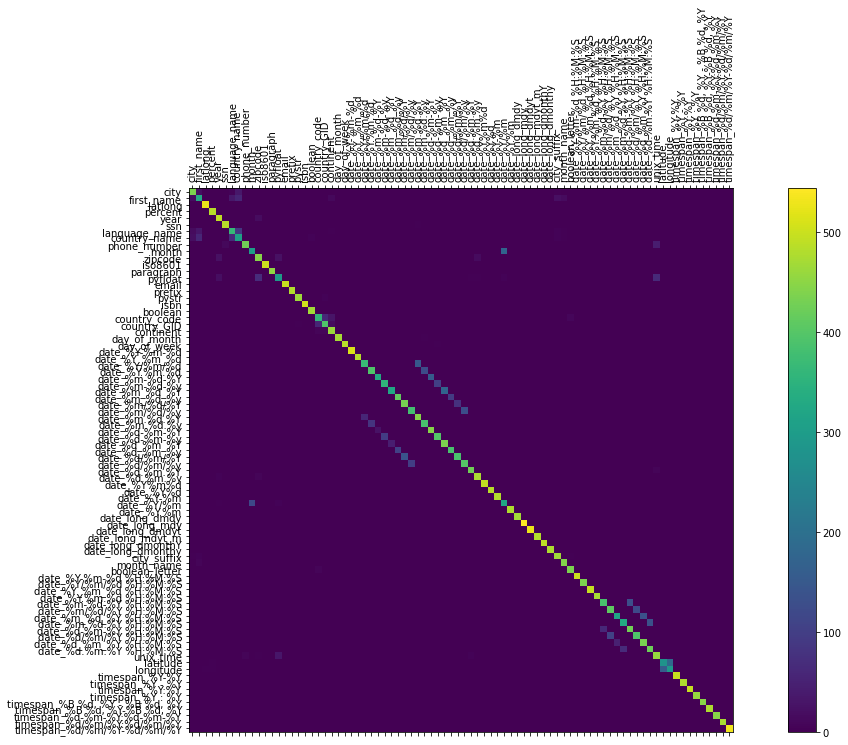

In [38]:
evaluate_test_set(model, test_split, char_vocab, tag_vocab)

In [30]:
# If the model performed well you can save it locally
yourpath = 'models/LSTM_RNN_Geotime_Classify_v_0.07.pth'
torch.save(model, yourpath)

In [40]:
torch.save(model.state_dict(), 'models/LSTM_RNN_Geotime_Classify_v_0.12_dict.pth')